# DS Practicum 1

**Team Members**
<br></br>
Gauri Rajesh, Jasmine Chen, Simran Sharma, Nathanael Dougherty

## Question 1

**Problem:**

## Question 2

**Loading Data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV with the correct filename
df = pd.read_csv("2019_ONTIME_REPORTING_FSW-1.csv")

# View the first 5 rows
df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,10/1/19,AA,N916NN,2311,TUS,AZ,ORD,IL,828.0,0.0,1353.0,0.0,205.0,1437
1,10/1/19,AA,N733UW,2315,PHX,AZ,DEN,CO,1907.0,0.0,2159.0,0.0,112.0,602
2,10/1/19,AA,N140AN,2318,DFW,TX,LAX,CA,1904.0,104.0,2016.0,101.0,192.0,1235
3,10/1/19,AA,N925AN,2325,SNA,CA,DFW,TX,1729.0,4.0,2215.0,3.0,166.0,1205
4,10/1/19,AA,N143AN,2328,ATL,GA,LAX,CA,656.0,0.0,841.0,0.0,285.0,1947


**Inspecting Data and Converting to Suitable Types**

In [2]:
# inspect the dimensions
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# inspect data types
df.info()

There are 1048575 rows and 14 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   FL_DATE       1048575 non-null  object 
 1   CARRIER_CODE  1048575 non-null  object 
 2   TAIL_NUM      1045459 non-null  object 
 3   FL_NUM        1048575 non-null  int64  
 4   ORIGIN        1048575 non-null  object 
 5   ORIGIN_ST     1048575 non-null  object 
 6   DEST          1048575 non-null  object 
 7   DEST_ST       1048575 non-null  object 
 8   DEP_TIME      1032926 non-null  float64
 9   DEP_DELAY     1032920 non-null  float64
 10  ARR_TIME      1032036 non-null  float64
 11  ARR_DELAY     1030216 non-null  float64
 12  ELAPSED_TIME  1030216 non-null  float64
 13  DISTANCE      1048575 non-null  int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 112.0+ MB


**Dimensions** <br></br>There are 1897503 rows and 14 columns of data.  

**Changes in Data Types**
<br></br>
CARRIER_CODE, TAIL_NUM, FL_NUM, ORIGIN, ORIGIN_ST, DEST, and DEST_ST will be changed to category variables because they represent labels.  FL_DATE will be changed to datetime because it represents a date.  DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, and ELAPSED_TIME will be changed to integers as well.

In [3]:
# change FL_DATE to datetime
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

# change CARRIER_CODE, TAIL_NUM, FL_NUM, ORIGIN, ORIGIN_ST, DEST, DEST_ST to
# categorical variables
df["FL_NUM"] = df["FL_NUM"].astype("category")
df["CARRIER_CODE"] = df["CARRIER_CODE"].astype("category")
df["TAIL_NUM"] = df["TAIL_NUM"].astype("category")
df["ORIGIN"] = df["ORIGIN"].astype("category")
df["ORIGIN_ST"] = df["ORIGIN_ST"].astype("category")
df["DEST"] = df["DEST"].astype("category")
df["DEST_ST"] = df["DEST_ST"].astype("category")

# change DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, ELAPSED_TIME to Int64
df["DEP_TIME"] = df["DEP_TIME"].astype("Int64")
df["DEP_DELAY"] = df["DEP_DELAY"].astype("Int64")
df["ARR_TIME"] = df["ARR_TIME"].astype("Int64")
df["ARR_DELAY"] = df["ARR_DELAY"].astype("Int64")
df["ELAPSED_TIME"] = df["ELAPSED_TIME"].astype("Int64")

# verify changes 
df.dtypes

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\407321059.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])


FL_DATE         datetime64[ns]
CARRIER_CODE          category
TAIL_NUM              category
FL_NUM                category
ORIGIN                category
ORIGIN_ST             category
DEST                  category
DEST_ST               category
DEP_TIME                 Int64
DEP_DELAY                Int64
ARR_TIME                 Int64
ARR_DELAY                Int64
ELAPSED_TIME             Int64
DISTANCE                 int64
dtype: object

In [4]:
# verify changes by checking first 5 rows
df.head()
original_df = df.copy()

In [5]:
# percentage of missing values
df.isnull().mean()*100

FL_DATE         0.000000
CARRIER_CODE    0.000000
TAIL_NUM        0.297165
FL_NUM          0.000000
ORIGIN          0.000000
ORIGIN_ST       0.000000
DEST            0.000000
DEST_ST         0.000000
DEP_TIME        1.492406
DEP_DELAY       1.492979
ARR_TIME        1.577283
ARR_DELAY       1.750852
ELAPSED_TIME    1.750852
DISTANCE        0.000000
dtype: float64

In [6]:
# distribution of missing values in rows
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts()

0    1030216
5      12535
6       3115
2       1820
3        884
4          5
Name: count, dtype: int64

**Missing Values**<br></br>Based on this information, missing data is not widespread since only a small percentage of rows have missing data.  Out of the rows with missing data, most have 5 or 6 missing columns.  Since the columns with missing values are related to arrival, departure, and delay times and this is important to the data science question on air traffic in part 1, these rows should be dropped.

In [7]:
# remove rows with null values
df = df.dropna()

# verify changes (only rows with 0 null values retained)
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts()

0    1030216
Name: count, dtype: int64

**Invalid Data**

Invalid times of 2400 for DEP_TIME were corrected by changing them to 0 and updating the FL_DATE by 1 day.  Rows with times of 2400 were not excluded since the data is not necessarily incorrect, just inconsistent since 2400 means 24 hours later or the next day.  This means the flight actually departed at midnight the next day.

In [8]:
# determine number of rows with invalid DEP_TIME
invalid_dep_time_df = df[df["DEP_TIME"] == 2400]
print(f"{invalid_dep_time_df.shape[0]} rows with invalid DEP_TIME values")
# display rows with invalid departure times to verify later
invalid_dep_time_df.head()

119 rows with invalid DEP_TIME values


,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
34864,2019-10-07,DL,N383DZ,487,LAS,NV,ATL,GA,2400,1,635,0,215,1747
40416,2019-10-08,AA,N825NN,1542,PHX,AZ,DCA,VA,2400,0,707,0,247,1979
50938,2019-10-10,DL,N841MH,1362,LAX,CA,JFK,NY,2400,5,817,0,317,2475
65478,2019-10-13,NK,N627NK,456,LAS,NV,ORD,IL,2400,0,517,0,197,1514
68336,2019-10-14,DL,N844MH,1362,LAX,CA,JFK,NY,2400,5,803,0,303,2475


There are 241 rows with invalid departure times.

In [9]:
# update rows with invalid DEP_TIME
dep_time_filter = df["DEP_TIME"] == 2400
df.loc[dep_time_filter, ["DEP_TIME", "FL_DATE"]] = (
    df.loc[dep_time_filter].assign(DEP_TIME=0, FL_DATE=lambda x: x["FL_DATE"] + pd.DateOffset(days=1))
)

# verify changes by checking that there are no rows with 2400 as DEP_TIME
new_dep_time_df = df[df["DEP_TIME"] == 2400]
print(f"{new_dep_time_df.shape[0]} rows with invalid DEP_TIME values")

# verify changes by checking that rows in dep_time_filter now have corrected dates
verify_dep_time_cleaning = invalid_dep_time_df.merge(df, on=["FL_NUM", "TAIL_NUM", "ARR_TIME", "DEP_DELAY"], how="inner", suffixes=("_before", "_cleaned"))
verify_dep_time_cleaning = verify_dep_time_cleaning[["FL_DATE_before", "DEP_TIME_before", "FL_DATE_cleaned", "DEP_TIME_cleaned"]]
verify_date_change = (verify_dep_time_cleaning["FL_DATE_cleaned"] - verify_dep_time_cleaning["FL_DATE_before"]).dt.days
verify_dep_change = verify_dep_time_cleaning["DEP_TIME_cleaned"] == 0
print("All dates with 2400 departure time corrected by 1 day: ", (verify_date_change == 1).all())
print("All dates with 2400 departure time corrected to 0: ", (verify_dep_change).all())

0 rows with invalid DEP_TIME values
All dates with 2400 departure time corrected by 1 day:  True
All dates with 2400 departure time corrected to 0:  True


There are now 0 rows with invalid departure times.

The other columns were checked for potential invalid data but no such values were found.  Checked for invalid CARRIER_CODE (not exactly two characters), FL_NUM(not exactly 1 to 4 digits), ORIGIN/DEST (not exactly 3 uppercase letters), ORIGIN_ST/DEST_ST (not exactly 2 uppercase letters), and DISTANCE (negative distances).  

**Additional Variable Checks**

In [10]:
# check for invalid CARRIER_CODE (not two characters)
carrier_code_check = df["CARRIER_CODE"].str.len() != 2
carrier_code_check_df = df[carrier_code_check]
print(f"There are {carrier_code_check_df.shape[0]} CARRIER_CODE entries that are not 2 characters")

There are 0 CARRIER_CODE entries that are not 2 characters


There are no CARRIER_CODE entries with IDs that are not 2 characters.

In [11]:
# check for invalid FL_NUM (not 1 to 4 digits)
fl_num_check = (df["FL_NUM"].astype("string").str.len() > 4) |  (df["FL_NUM"].astype("string").str.len() == 0)
fl_num_check_df = df[fl_num_check]
print(f"There are {fl_num_check_df.shape[0]} FL_NUM entries that are not 1 to 4 digits")

There are 0 FL_NUM entries that are not 1 to 4 digits


There are no FL_NUM entries with values that are not 1 to 4 characters.

In [12]:
# check for invalid ORIGIN/DEST that does not have 3 characters
origin_check = df["ORIGIN"].astype("string").str.len() != 3
origin_check_df = df[origin_check]
print(f"There are {origin_check_df.shape[0]} ORIGIN entries that are not 3 characters.")
dest_check = df["DEST"].astype("string").str.len() != 3
dest_check_df = df[dest_check]
print(f"There are {dest_check_df.shape[0]} DEST entries that are not 3 characters.")

There are 0 ORIGIN entries that are not 3 characters.
There are 0 DEST entries that are not 3 characters.


There are no ORIGIN or DEST entries with values that are not 3 characters long.

In [13]:
# check for invalid ORIGIN_ST/DEST_ST that does not have 2 characters
originst_check = df["ORIGIN_ST"].astype("string").str.len() != 2
originst_check_df = df[originst_check]
print(f"There are {originst_check_df.shape[0]} ORIGIN_ST entries that are not 2 characters.")
destst_check = df["DEST_ST"].astype("string").str.len() != 2
destst_check_df = df[destst_check]
print(f"There are {destst_check_df.shape[0]} DEST_ST entries that are not 2 characters.")

There are 0 ORIGIN_ST entries that are not 2 characters.
There are 0 DEST_ST entries that are not 2 characters.


There are no ORIGIN_ST or DEST_ST entries with values that are not 3 characters long.

In [14]:
# check for invalid DISTANCE that is negative
dist_check = df["DISTANCE"] < 0
dist_check_df = df[dist_check]
print(f"There are {dist_check_df.shape[0]} DISTANCE entries with negative values")

There are 0 DISTANCE entries with negative values


There are no DISTANCE entries that have negative values

**High Level Overview of Dataset: Airline Carriers and Delays**

In [15]:
print(f"There are {df['CARRIER_CODE'].unique().size} different airline carriers")

There are 15 different airline carriers


In [16]:
# create new data frame with just departure delays and origin airports
origin_airport_delay_avg_df = df.groupby("ORIGIN_ST", observed=True)[["DEP_DELAY"]].mean()
# create new data frame with just arrival delays and destination airports
dest_airport_delay_avg_df = df.groupby("DEST_ST", observed=True)[["ARR_DELAY"]].mean()

In [17]:
# create new data frame with just carrier codes and delays
carrier_delay_df_avg = df.groupby("CARRIER_CODE", observed=True)[["ARR_DELAY", "DEP_DELAY"]].mean()
carrier_delay_df_std = df.groupby("CARRIER_CODE", observed=True)[["ARR_DELAY", "DEP_DELAY"]].std()
carrier_delay_df_avg.head()


,ARR_DELAY,DEP_DELAY
CARRIER_CODE,,
AA,13.979974,13.729003
AS,12.099822,10.747917
B6,15.389422,15.371686
DL,10.160912,10.314351
EV,9.263889,8.0


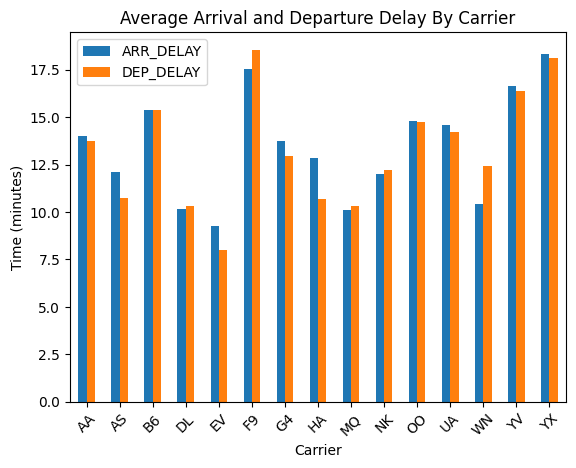

In [18]:
# visualize results
carrier_delay_df_avg.plot(y=["ARR_DELAY", "DEP_DELAY"], kind="bar")
plt.title("Average Arrival and Departure Delay By Carrier")
plt.ylabel("Time (minutes)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()

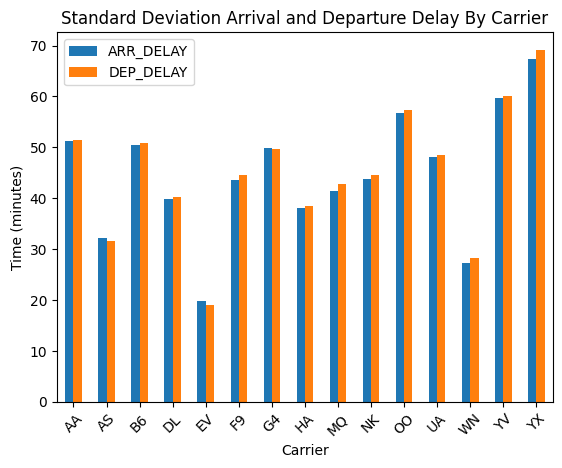

In [19]:
carrier_delay_df_std.plot(y=["ARR_DELAY", "DEP_DELAY"], kind="bar")
plt.title("Standard Deviation Arrival and Departure Delay By Carrier")
plt.ylabel("Time (minutes)")
plt.xlabel("Carrier")
plt.xticks(rotation=45)
plt.show()

**Arrival and Departure Delay Analysis**
<br></br>
Based on the average delay data, carriers F9, YX, and B6 are the most prone to arrival along with departure delays.  The carriers with the least delays are DL, WN, and MO.  Examining the standard devation of delays across carriers shows that the carrier with the greatest variation in arrival and departure delays is YX of almost 70 minutes.  The carrier with the least variability in terms of delays is EV with just under 20 minutes.  Therefore, VW flights tend to have lower delays and have more consistent delay patterns.  In contrast, YX flights tend to have greater delays and less consistent delay patterns.  Generally across airline carriers, the variability of delay patterns are similar for arrival and departure delays.  This may imply that flight carriers have similar patterns of arrival and departure delays.  


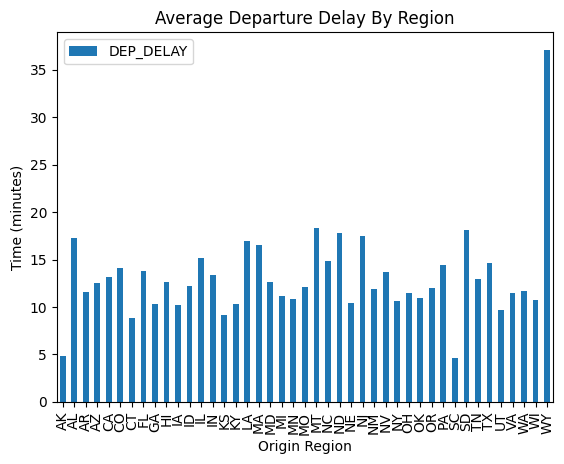

In [20]:
# visualize results
origin_airport_delay_avg_df.plot(y=["DEP_DELAY"], kind="bar")
plt.title("Average Departure Delay By Region")
plt.ylabel("Time (minutes)")
plt.xlabel("Origin Region")
plt.show()

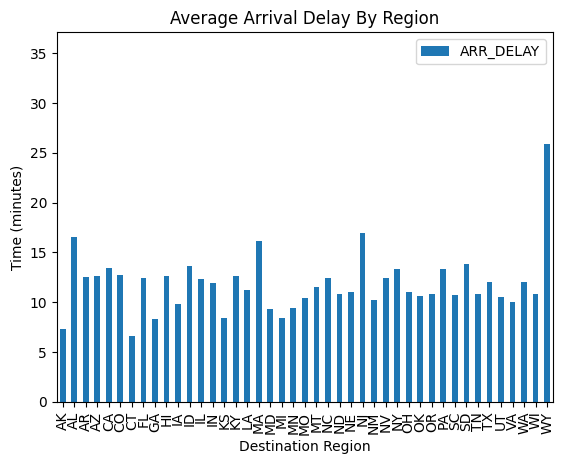

In [21]:
# visualize results
dest_airport_delay_avg_df.plot(y=["ARR_DELAY"], kind="bar")
plt.title("Average Arrival Delay By Region")
plt.ylabel("Time (minutes)")
plt.ylim(0, max(origin_airport_delay_avg_df['DEP_DELAY']))
plt.xlabel("Destination Region")
plt.show()

**Arrival and Departure Delay Analysis Continued**
<br></br>
Based on the average arrival and departure delays by region, WY demonstrated longer delays compared to other regions.  AK and SC had the shortest departure delays while CT and AK had the shortest arrival delays.  This data can be further analyzed to determine if certain routes or regions may be associated with longer carrier delays.  Significant airport delays may also contribute to increased airport traffic.  However, for the most part, regions have similar arrival and departure delays between 5 and 20 minutes.

**High Level Overview: Air Traffic at Certain Regions**

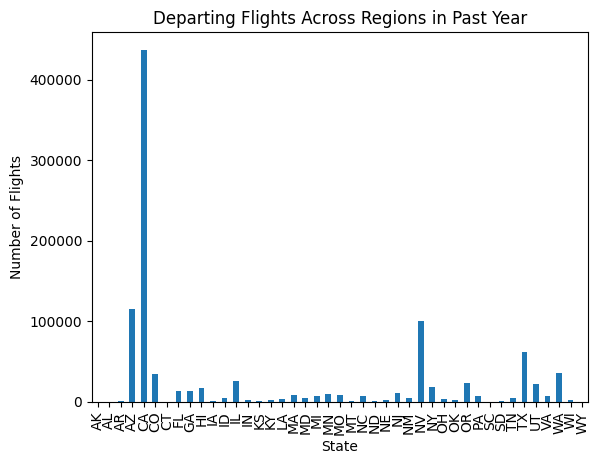

In [22]:
air_traffic_overview_departing_df = df.groupby("ORIGIN_ST", observed=True).size()
air_traffic_overview_departing_df.plot(y=["ORIGIN_ST"], kind="bar")
plt.title("Departing Flights Across Regions in Past Year")
plt.ylabel("Number of Flights")
plt.xlabel("State")
plt.show()

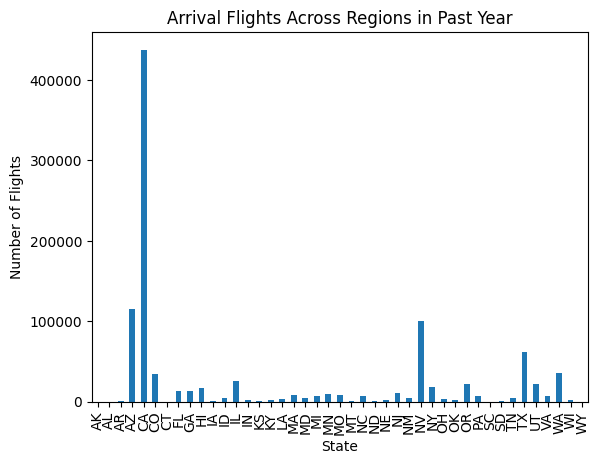

In [23]:
air_traffic_overview_arrival_df = df.groupby("DEST_ST", observed=True).size()
air_traffic_overview_arrival_df.plot(y=["DEST_ST"], kind="bar")
plt.title("Arrival Flights Across Regions in Past Year")
plt.ylabel("Number of Flights")
plt.xlabel("State")
plt.show()

**Air Traffic**
<br></br>
Based on the number of arriving and departing flights across regions in the past year worth of data, CA dominates in terms of total flights, followed by AZ and NV.  Therefore, air traffic is greatest at CA, AZ, and NV based on measures of total flights.  Several regions including AK, AL, and SC have significantly less arriving and departing flights in comparison.  Therefore, these states likely have the least amount of air traffic.

**Summary Statistics**

In [24]:
avg_fl_date = df['FL_DATE'].mean()
mode_carrier_code = df['CARRIER_CODE'].mode().iloc[0]
mode_origin_st = df['ORIGIN_ST'].mode().iloc[0]
mode_dest_st = df['DEST_ST'].mode().iloc[0]
avg_dep_time = df['DEP_TIME'].mean()
avg_dep_delay = df['DEP_DELAY'].mean()
avg_arr_time = df['ARR_TIME'].mean()
avg_arr_delay = df['ARR_DELAY'].mean()
avg_distance = df['DISTANCE'].mean()
std_distance = df['DISTANCE'].std()
avg_elapsed_time = df['ELAPSED_TIME'].mean()
std_elapsed_time = df['ELAPSED_TIME'].std()

print(f"mean flight date: {avg_fl_date}")
print(f"mode carrier code: {mode_carrier_code}")
print(f"mode origin: {mode_origin_st}")
print(f"mode destination: {mode_dest_st}")
print(f"average departure time: {avg_dep_time}")
print(f"average departure delay: {avg_dep_delay}")
print(f"average arrival time: {avg_arr_time}")
print(f"average arrival delay: {avg_arr_delay}")
print(f"average distance: {avg_distance}")
print(f"std distance: {std_distance}")
print(f"average elapsed time: {avg_elapsed_time}")
print(f"std elapsed time: {std_elapsed_time}")

mean flight date: 2019-07-12 23:10:24.605325056
mode carrier code: WN
mode origin: CA
mode destination: CA
average departure time: 1340.044496493939
average departure delay: 13.0794648889165
average arrival time: 1475.061139605675
average arrival delay: 12.704296962966989
average distance: 1144.9501502597514
std distance: 754.4431850858905
average elapsed time: 175.163655971175
std elapsed time: 93.15692830824261


**General Statistics**
<br></br>
Based on the summary statistics, the average flight date was 7/3/2019, indicating that the flight data has a relatively even spread since July is close to the middle of the year.  The most common carrier code was WN, which based on the previous data on delays, seems to have some of the lowest arrival and departure delays compared to other carriers.  Therefore, WN seems to be the least prone to delays.  The mode origin and destination were both CA, indicating that there is likely high air traffic in this region due to the number of incoming as well as outgoing flights.  Both arrival and departure times tend to have a similar average delay, which was also reflected in the previous charts.  The average distance is 1146.86 and this can vary by about 756.42 based on the standard deviation.  This can be reviewed on a region basis since longer average distances might indicate the presense of more international flights at an airport.  Lower average distances might indicate a more regional airport with high or low traffic based on other measures like the number of arriving or departing flights. The average elapsed time is 174.81 and the standard deviation of this time is 92.73.  Similar to the distances, this can be reviewed on a region basis to further determine air traffic at specific locations.

## Question 3

1. Explore patterns in the region i.e. the 3 states (AZ, NV, CA). Determine which region has the most air traffic. Comment on your findings and visualize the results. Note: it's important to explain your rational for determining what is "the most air traffic". For example, are you evaluating the frequency of flights or total flight time. Justify your response.

In [25]:
# filter data for AZ, NV, and CA
states = ['AZ', 'NV', 'CA']
state_filter = df['ORIGIN_ST'].isin(states) | df['DEST_ST'].isin(states)
filtered_df = df[state_filter]
# verify results by checking how many rows don't have an original location or destination of one of the specified states
invalidRows = filtered_df[~df['ORIGIN_ST'].isin(states) & ~df['DEST_ST'].isin(states)].shape[0]
print(f"There are {invalidRows} rows without an original location or destination of AZ, NV, or CA")

There are 0 rows without an original location or destination of AZ, NV, or CA


In [26]:
# determine time span of data
filtered_df['FL_DATE'].value_counts(ascending=True)

FL_DATE
2020-01-01       1
2019-05-23     669
2019-11-28    3547
2019-02-02    3829
2019-02-09    3980
              ... 
2019-12-26    5526
2019-12-23    5529
2019-12-29    5545
2019-12-30    5551
2019-12-27    5559
Name: count, Length: 205, dtype: int64

**Criteria For Most Air Traffic**
<br></br>
The region with the most air traffice will be determined by analyzing the frequency of flights that have arrived at that region and the frequency of flights that have departed from that region between August 9, 2019 and January 1, 2020.  The number of incoming and outgoing flights per day from each region will be analyzed in particular.

In [27]:
# airport data from AZ
az_filter = df['ORIGIN_ST'].isin(['AZ']) | df['DEST_ST'].isin(['AZ'])
az_airport_df = filtered_df[az_filter]
az_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828,0,1353,0,205,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907,0,2159,0,112,602
5,2019-10-01,AA,N816NN,2339,PHX,AZ,JFK,NY,911,0,1702,0,291,2153
10,2019-10-01,AA,N982AN,2369,JFK,NY,PHX,AZ,1053,0,1250,0,297,2153
11,2019-10-01,AA,N177US,2371,EWR,NJ,PHX,AZ,941,0,1155,0,314,2133


In [28]:
# number of flights that arrived at AZ in past year
az_airport_df_arrival = az_airport_df[az_airport_df["DEST_ST"] == 'AZ']
print(f"{az_airport_df_arrival.shape[0]} flights arrived at AZ in past year")

115490 flights arrived at AZ in past year


In [29]:
# count number of flights per day that arrive at AZ
az_arrival_flights_per_day = az_airport_df_arrival.groupby("FL_DATE").size()

**AZ Arrival Flights Per Day Statistics**

In [30]:
# calculate statistics for flight frequencies
az_mean_arrival_flights = az_arrival_flights_per_day.mean()
az_median_arrival_flights = az_arrival_flights_per_day.median()
az_mode_arrival_flights = az_arrival_flights_per_day.mode().iloc[0]
az_std_arrival_flights = az_arrival_flights_per_day.std()
print("AZ Arrival Flights Per Day Statistics:")
print(f"mean: {az_mean_arrival_flights}")
print(f"median: {az_median_arrival_flights}")
print(f"mode: {az_mode_arrival_flights}")
print(f"std: {az_std_arrival_flights}")

AZ Arrival Flights Per Day Statistics:
mean: 566.1274509803922
median: 573.0
mode: 565
std: 52.81386061701461


In [31]:
# number of flights that departed from AZ in past year
az_airport_df_departure = az_airport_df[az_airport_df["ORIGIN_ST"] == 'AZ']
print(f"{az_airport_df_departure.shape[0]} flights departed from AZ in past year")

115435 flights departed from AZ in past year


In [32]:
# count number of flights per day that depart from AZ
az_departure_flights_per_day = az_airport_df_departure.groupby("FL_DATE").size()

**AZ Departure Flights Per Day Statistics**

In [33]:
# calculate statistics for flight frequencies
az_mean_departure_flights = az_departure_flights_per_day.mean()
az_median_departure_flights = az_departure_flights_per_day.median()
az_mode_departure_flights = az_departure_flights_per_day.mode().iloc[0]
az_std_departure_flights = az_departure_flights_per_day.std()
print("AZ Departure Flights Per Day Statistics:")
print(f"mean: {az_mean_departure_flights}")
print(f"median: {az_median_departure_flights}")
print(f"mode: {az_mode_departure_flights}")
print(f"std: {az_std_departure_flights}")

AZ Departure Flights Per Day Statistics:
mean: 568.6453201970444
median: 572.0
mode: 571
std: 40.62801934273683


In [34]:
# airport data from NV
nv_filter = df['ORIGIN_ST'].isin(['NV']) | df['DEST_ST'].isin(['NV'])
nv_airport_df = filtered_df[nv_filter]
nv_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
14,2019-10-01,AA,N352PS,2390,DFW,TX,LAS,NV,2225,0,2310,0,165,1055
16,2019-10-01,AA,N953NN,2407,LAS,NV,ORD,IL,1143,0,1716,0,213,1514
22,2019-10-01,AA,N922AN,2427,ORD,IL,RNO,NV,1216,0,1432,0,256,1671
23,2019-10-01,AA,N922AN,2427,RNO,NV,ORD,IL,1523,0,2143,18,260,1671
28,2019-10-01,AA,N305NX,2448,DFW,TX,RNO,NV,1722,0,1839,0,197,1345


In [35]:
# number of flights that arrived at NV in past year
nv_airport_df_arrival = nv_airport_df[nv_airport_df["DEST_ST"] == 'NV']
print(f"{nv_airport_df_arrival.shape[0]} flights arrived at NV in past year")

100094 flights arrived at NV in past year


In [36]:
# count number of flights per day that arrive at NV
nv_arrival_flights_per_day = nv_airport_df_arrival.groupby("FL_DATE").size()

**NV Arrival Flights Per Day Statistics:**

In [37]:
# calculate statistics for flight frequencies
nv_mean_arrival_flights = nv_arrival_flights_per_day.mean()
nv_median_arrival_flights = nv_arrival_flights_per_day.median()
nv_mode_arrival_flights = nv_arrival_flights_per_day.mode().iloc[0]
nv_std_arrival_flights = nv_arrival_flights_per_day.std()
print("NV Arrival Flights Per Day Statistics:")
print(f"mean: {nv_mean_arrival_flights}")
print(f"median: {nv_median_arrival_flights}")
print(f"mode: {nv_mode_arrival_flights}")
print(f"std: {nv_std_arrival_flights}")

NV Arrival Flights Per Day Statistics:
mean: 490.65686274509807
median: 501.5
mode: 506
std: 51.90508486115906


In [38]:
# number of flights that departed from NV in past year
nv_airport_df_departure = nv_airport_df[nv_airport_df["ORIGIN_ST"] == 'NV']
print(f"{nv_airport_df_departure.shape[0]} flights departed from NV in past year")

100228 flights departed from NV in past year


In [39]:
# count number of flights per day that depart from NV
nv_departure_flights_per_day = nv_airport_df_departure.groupby("FL_DATE").size()

**NV Departure Flights Per Day Statistics**

In [40]:
# calculate statistics for flight frequencies
nv_mean_departure_flights = nv_departure_flights_per_day.mean()
nv_median_departure_flights = nv_departure_flights_per_day.median()
nv_mode_departure_flights = nv_departure_flights_per_day.mode().iloc[0]
nv_std_departure_flights = nv_departure_flights_per_day.std()
print("NV Departure Flights Per Day Statistics:")
print(f"mean: {nv_mean_departure_flights}")
print(f"median: {nv_median_departure_flights}")
print(f"mode: {nv_mode_departure_flights}")
print(f"std: {nv_std_departure_flights}")

NV Departure Flights Per Day Statistics:
mean: 491.3137254901961
median: 502.0
mode: 506
std: 47.966117021408614


In [41]:
# airport data from CA
ca_filter = df['ORIGIN_ST'].isin(['CA']) | df['DEST_ST'].isin(['CA'])
ca_airport_df = filtered_df[ca_filter]
ca_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904,104,2016,101,192,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729,4,2215,3,166,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656,0,841,0,285,1947
6,2019-10-01,AA,N150NN,2349,LAX,CA,BOS,MA,2149,0,559,0,310,2611
7,2019-10-01,AA,N994AN,2354,LAX,CA,DFW,TX,1128,0,1620,0,172,1235


In [42]:
# number of flights that arrived at CA in past year
ca_airport_df_arrival = ca_airport_df[ca_airport_df["DEST_ST"] == 'CA']
print(f"{ca_airport_df_arrival.shape[0]} flights arrived at CA in past year")

437510 flights arrived at CA in past year


In [43]:
# count number of flights per day that arrive at AZ
ca_arrival_flights_per_day = ca_airport_df_arrival.groupby("FL_DATE").size()

**CA Arrival Flights Per Day Statistics:**

In [44]:
# calculate statistics for flight frequencies
ca_mean_arrival_flights = ca_arrival_flights_per_day.mean()
ca_median_arrival_flights = ca_arrival_flights_per_day.median()
ca_mode_arrival_flights = ca_arrival_flights_per_day.mode().iloc[0]
ca_std_arrival_flights = ca_arrival_flights_per_day.std()
print("CA Arrival Flights Per Day Statistics:")
print(f"mean: {ca_mean_arrival_flights}")
print(f"median: {ca_median_arrival_flights}")
print(f"mode: {ca_mode_arrival_flights}")
print(f"std: {ca_std_arrival_flights}")

CA Arrival Flights Per Day Statistics:
mean: 2134.1951219512193
median: 2195.0
mode: 2156
std: 265.6679354699628


In [45]:
# number of flights that departed from AZ in past year
ca_airport_df_departure = ca_airport_df[ca_airport_df["ORIGIN_ST"] == 'CA']
print(f"{ca_airport_df_departure.shape[0]} flights departed from CA in past year")

437312 flights departed from CA in past year


In [46]:
# count number of flights per day that depart from CA
ca_departure_flights_per_day = ca_airport_df_departure.groupby("FL_DATE").size()

**CA Departure Flights Per Day Statistics**

In [47]:
# calculate statistics for flight frequencies
ca_mean_departure_flights = ca_departure_flights_per_day.mean()
ca_median_departure_flights = ca_departure_flights_per_day.median()
ca_mode_departure_flights = ca_departure_flights_per_day.mode().iloc[0]
ca_std_departure_flights = ca_departure_flights_per_day.std()
print("CA Departure Flights Per Day Statistics:")
print(f"mean: {ca_mean_departure_flights}")
print(f"median: {ca_median_departure_flights}")
print(f"mode: {ca_mode_departure_flights}")
print(f"std: {ca_std_departure_flights}")

CA Departure Flights Per Day Statistics:
mean: 2143.6862745098038
median: 2205.5
mode: 2155
std: 225.59755267128682


**Visualize AZ, NV, and CA Flights Per Day**

In [48]:
flights_per_day_arrival = {
    'State': ['AZ', 'NV', 'CA'],
    'Mean': [az_mean_arrival_flights, nv_mean_arrival_flights, ca_mean_arrival_flights],
    'Median': [az_median_arrival_flights, nv_median_arrival_flights, ca_median_arrival_flights],
    'Mode': [az_mode_arrival_flights, nv_mode_arrival_flights, ca_mode_arrival_flights],
    'Std Dev': [az_std_arrival_flights, nv_std_arrival_flights, ca_std_arrival_flights]
}

flights_per_day_departure = {
    'State': ['AZ', 'NV', 'CA'],
    'Mean': [az_mean_departure_flights, nv_mean_departure_flights, ca_mean_departure_flights],
    'Median': [az_median_departure_flights, nv_median_departure_flights, ca_median_departure_flights],
    'Mode': [az_mode_departure_flights, nv_mode_departure_flights, ca_mode_departure_flights],
    'Std Dev': [az_std_departure_flights, nv_std_departure_flights, ca_std_departure_flights]
}

flights_per_day_arrival_df = pd.DataFrame(flights_per_day_arrival)
flights_per_day_departure_df = pd.DataFrame(flights_per_day_departure)

**Flights Per Day Arrival**

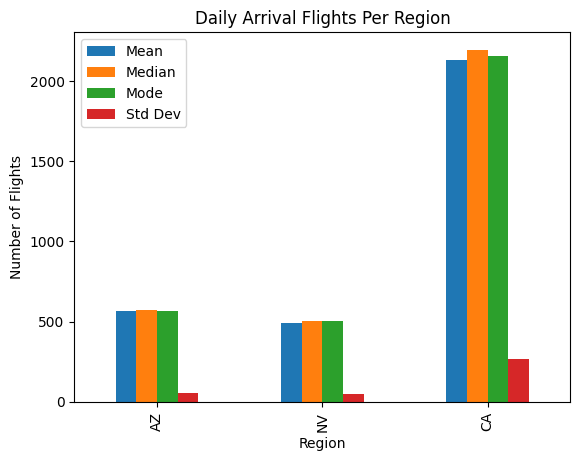

In [49]:
flights_per_day_arrival_df.index = ['AZ', 'NV', 'CA']
flights_per_day_arrival_df.plot(y=["Mean", "Median", "Mode", "Std Dev"], kind="bar")
plt.title("Daily Arrival Flights Per Region")
plt.ylabel("Number of Flights")
plt.xlabel("Region")
plt.show()

**Flights Per Day Departure**

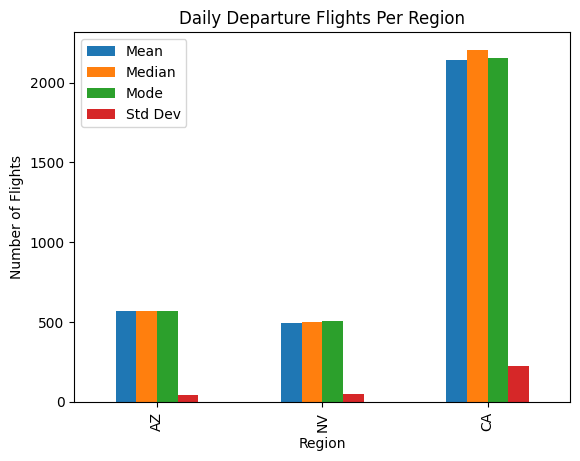

In [50]:
flights_per_day_departure_df.index = ['AZ', 'NV', 'CA']
flights_per_day_departure_df.plot(y=["Mean", "Median", "Mode", "Std Dev"], kind="bar")
plt.title("Daily Departure Flights Per Region")
plt.ylabel("Number of Flights")
plt.xlabel("Region")
plt.show()

**Analysis**

Based on the provided data, CA has the most air traffic as it has the greatest average arrival and departure flights per day.  CA has an average of 2183 arrival and 2188 departure flights daily.  AZ has an average of 552 arrival and 552 departure flights daily, while NV has an average of 498 arrival and 498 departure flights daily.

Based on the graph results, CA clearly dominates in terms of number of flights and has a greater standard deviation, indicating more daily variability than the other two regions.  AZ and NV have similar means and medians with low standard deviations, implying more consistent day to day air traffic.  Since the mean, median, and mode are similar for all regions in terms of arrival and departure flights per day, this means that there are no extreme daily flight flight values affecting the average.

In terms of total number of flights, AZ, NV, and CA had 201744, 182115, and 798690 arrival flights in the past year respectively.  AZ, NV, and CA had 201804, 181985, and 799137 departure flights in the past year respectively.  This further proves that CA has the greatest air traffic, followed by AZ and then NV based on measures of daily fights.  


2. For each region, the 3 states (AZ, NV, CA), analyze the MOST POPULAR outbound/destination airports. For example, if a flight originated in CA (at any of its airports), where do they often go? Comment on your findings and visualize the results for the top 5 destinations.

**Average Arrival Delay by Carrier**

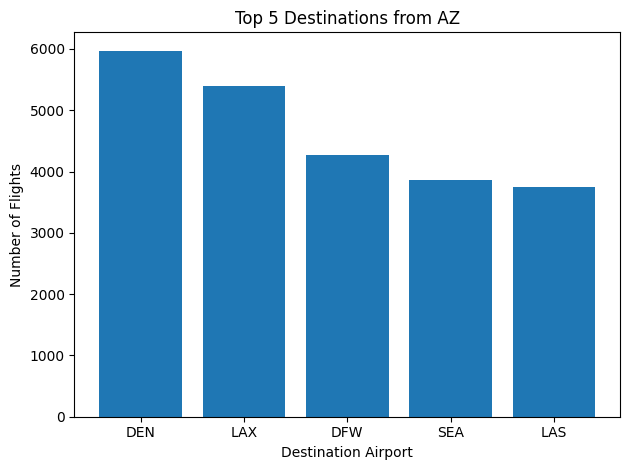

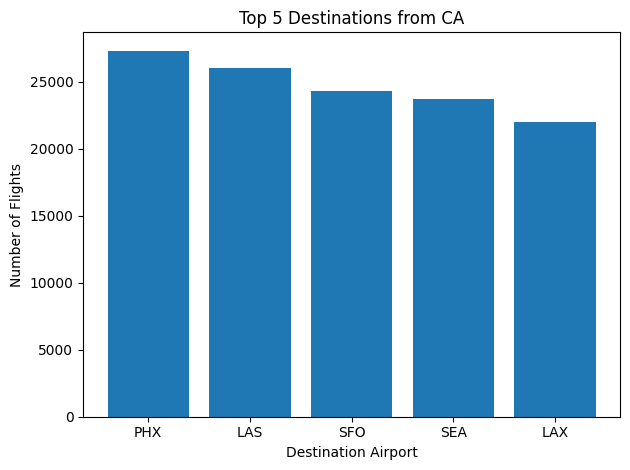

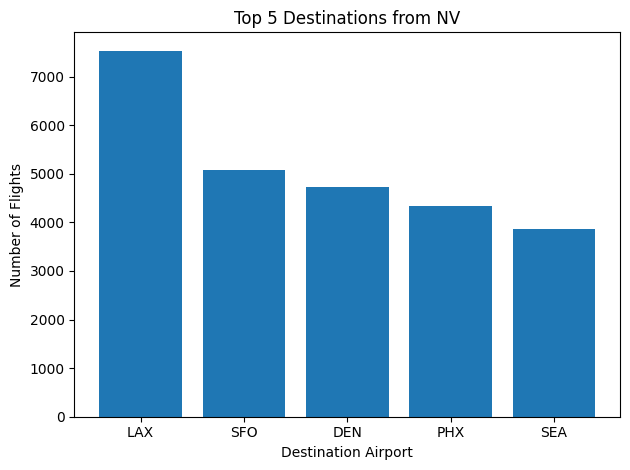

{'AZ':   DEST  FLIGHT_COUNT
 0  DEN          5973
 1  LAX          5400
 2  DFW          4268
 3  SEA          3870
 4  LAS          3752,
 'CA':   DEST  FLIGHT_COUNT
 0  PHX         27329
 1  LAS         26069
 2  SFO         24315
 3  SEA         23698
 4  LAX         22017,
 'NV':   DEST  FLIGHT_COUNT
 0  LAX          7534
 1  SFO          5083
 2  DEN          4723
 3  PHX          4328
 4  SEA          3867}

In [51]:
import matplotlib.pyplot as plt

states = ['AZ', 'CA', 'NV']

def top_destinations_by_state(df, top_n=5):
    results = {}
    for state in states:
        subset = df[df['ORIGIN_ST'] == state]
        top_dest = (
            subset['DEST']
            .value_counts()
            .head(top_n)
            .to_frame(name='FLIGHT_COUNT')
            .reset_index()
            .rename(columns={'index': 'DEST'})
        )
        results[state] = top_dest

        plt.figure()
        plt.bar(top_dest['DEST'], top_dest['FLIGHT_COUNT'])
        plt.title(f"Top {top_n} Destinations from {state}")
        plt.xlabel("Destination Airport")
        plt.ylabel("Number of Flights")
        plt.tight_layout()
        plt.show()
    return results

top_destinations_by_state(df, top_n=5)

**Analysis**

The most common outbound destinations show strong regional travel corridors. From Arizona, flights most frequently go to Denver and Los Angeles, while Nevada heavily favors flights to Los Angeles and San Francisco, reflecting strong California-bound demand. California sends large volumes to Phoennix, Las Vegas, and Seattle, showing intra-western connectivity. These results confirm that western US routes dominate traffic patterns from these states.

3. For each region, calculate the PROPORTION of flights from each airline/operator. Visualize the top 10 results. Explain the results.

Hint: Don't forget that proportion is an explicit requirement

**Top 10 Airline Proportions by State**

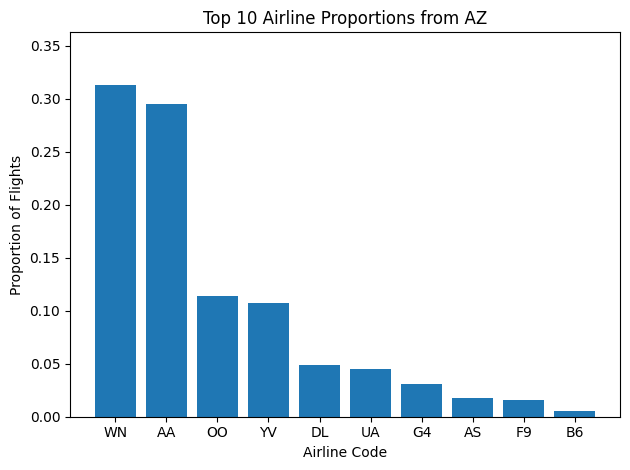

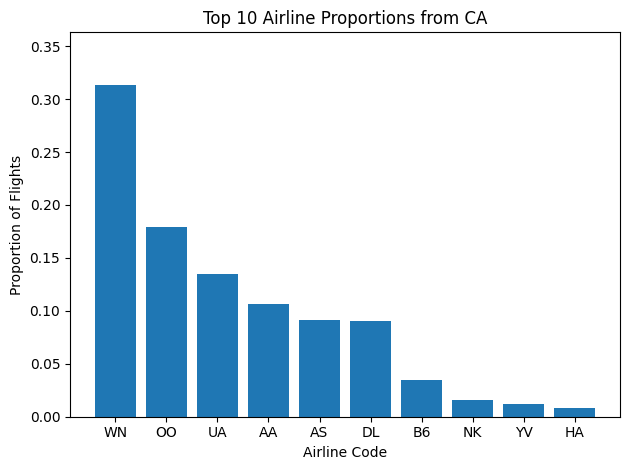

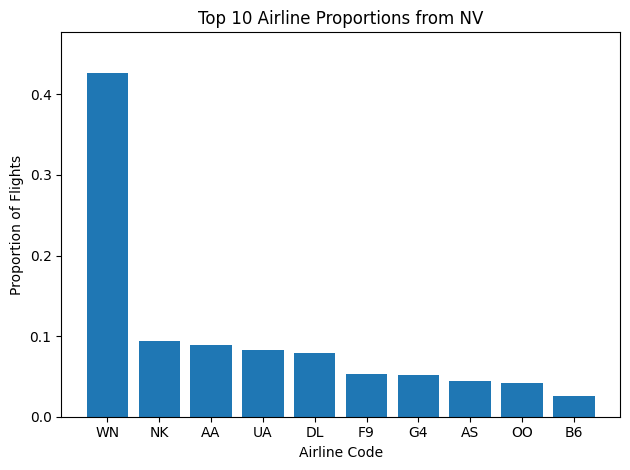

{'AZ':   CARRIER_CODE  PROPORTION
 0           WN    0.312505
 1           AA    0.295344
 2           OO    0.114281
 3           YV    0.107350
 4           DL    0.048798
 5           UA    0.045290
 6           G4    0.030849
 7           AS    0.017984
 8           F9    0.015645
 9           B6    0.005128,
 'CA':   CARRIER_CODE  PROPORTION
 0           WN    0.313042
 1           OO    0.178872
 2           UA    0.134558
 3           AA    0.106681
 4           AS    0.091280
 5           DL    0.090786
 6           B6    0.034316
 7           NK    0.015817
 8           YV    0.012106
 9           HA    0.008328,
 'NV':   CARRIER_CODE  PROPORTION
 0           WN    0.426976
 1           NK    0.094085
 2           AA    0.088378
 3           UA    0.083150
 4           DL    0.078711
 5           F9    0.053279
 6           G4    0.051792
 7           AS    0.044179
 8           OO    0.041984
 9           B6    0.025422}

In [52]:
def airline_proportions(df, top_n=10):
    proportions_by_state = {}
    for state in states:
        subset = df[df['ORIGIN_ST'] == state]
        counts = subset['CARRIER_CODE'].value_counts(normalize=True).head(top_n)
        proportions = counts.to_frame(name='PROPORTION').reset_index().rename(columns={'index': 'CARRIER_CODE'})
        proportions_by_state[state] = proportions

        # Plot
        plt.figure()
        plt.bar(proportions['CARRIER_CODE'], proportions['PROPORTION'])
        plt.title(f"Top {top_n} Airline Proportions from {state}")
        plt.xlabel("Airline Code")
        plt.ylabel("Proportion of Flights")
        plt.ylim(0, proportions['PROPORTION'].max() + 0.05)
        plt.tight_layout()
        plt.show()

    return proportions_by_state

airline_proportions(df, top_n=10)

The airline proportions by region reveal that Southwest Airlines (WN) dominates in all three states, especially in Nevada where it operates over 42% of all outbound flights. California has the most diversified market, which multiple carriers (WN, OO, UA, AA) share the volume more evenly, while regional airlines like SkyWest (OO) and Mesa (YV) also have a significant presence in AZ and CA. These patterns suggest differences in market share and operational strategy by region.

## Question 4

1. Explore the carriers within the dataset and demonstrate at least TWO (2) patterns that you identified.

**Averge Arrival Delay by Carrier**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\85527309.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_summary = df.groupby('CARRIER_CODE')['ARR_DELAY'].mean().sort_values()


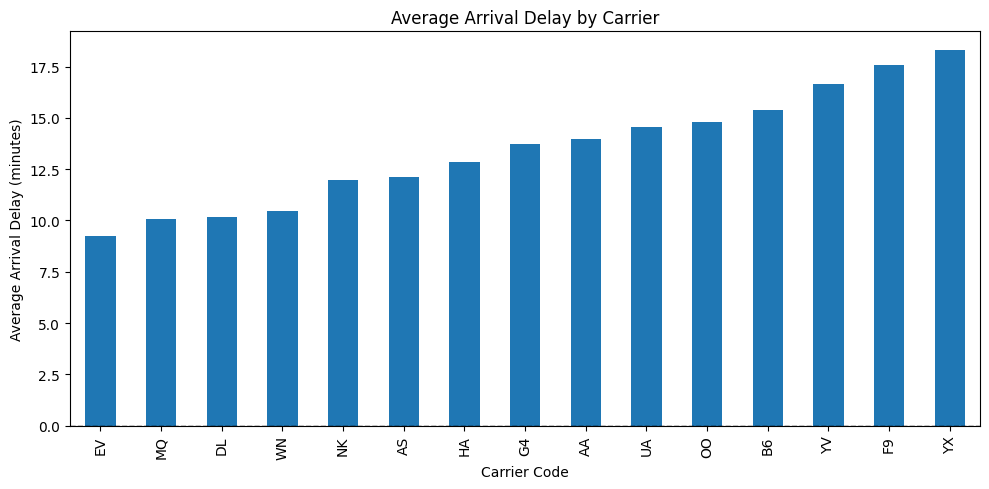

CARRIER_CODE
EV     9.263889
MQ    10.083961
DL    10.160912
WN    10.443905
NK    11.982639
AS    12.099822
HA    12.828899
G4    13.736686
AA    13.979974
UA    14.560239
OO    14.817936
B6    15.389422
YV    16.641621
F9    17.561047
YX    18.301587
Name: ARR_DELAY, dtype: Float64

In [53]:
def avg_arrival_delay(df):
    delay_summary = df.groupby('CARRIER_CODE')['ARR_DELAY'].mean().sort_values()
    delay_summary.plot(kind='bar', figsize=(10, 5))
    plt.title("Average Arrival Delay by Carrier")
    plt.xlabel("Carrier Code")
    plt.ylabel("Average Arrival Delay (minutes)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
    return delay_summary

avg_arrival_delay(df)

This graph shows the average arrival and departure delays for each airline, highlighting which carriers are most prone to delays.

**Missing Arrival or Elapsed Time by Carrer**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\3547183738.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_counts = df[missing_mask].groupby('CARRIER_CODE').size().sort_values(ascending=False)


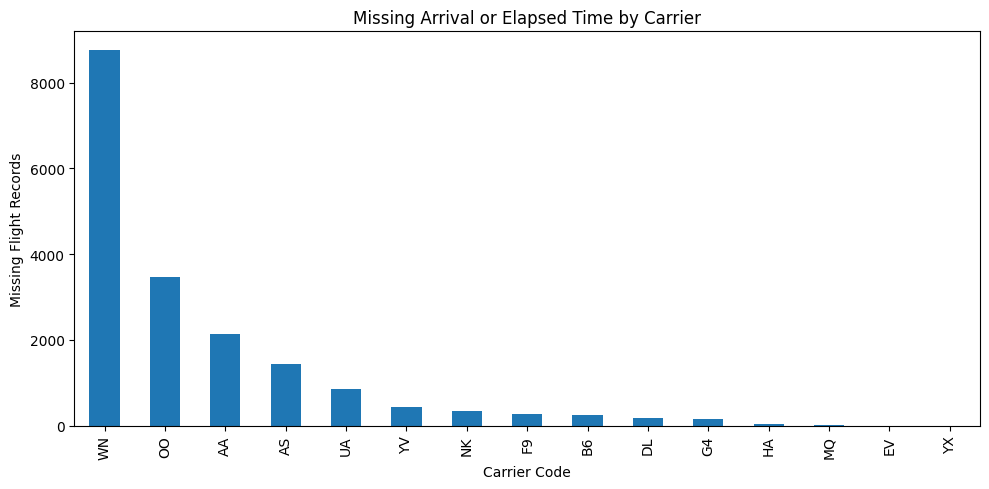

CARRIER_CODE
WN    8762
OO    3473
AA    2147
AS    1440
UA     858
YV     433
NK     335
F9     267
B6     245
DL     174
G4     163
HA      47
MQ      15
EV       0
YX       0
dtype: int64

In [54]:
def missing_flight_data(df):
    missing_mask = df['ARR_TIME'].isnull() | df['ELAPSED_TIME'].isnull()
    missing_counts = df[missing_mask].groupby('CARRIER_CODE').size().sort_values(ascending=False)
    missing_counts.plot(kind='bar', figsize=(10, 5))
    plt.title("Missing Arrival or Elapsed Time by Carrier")
    plt.xlabel("Carrier Code")
    plt.ylabel("Missing Flight Records")
    plt.tight_layout()
    plt.show()
    return missing_counts

missing_flight_data(original_df)

This graph shows the number of flights with missing arrival or elapsed time per airline, which can indicate data quality or operational issues.

**Departure Time Distribution by Carrier**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\2294398493.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['CARRIER_CODE', 'DEP_PERIOD']).size().unstack(fill_value=0)


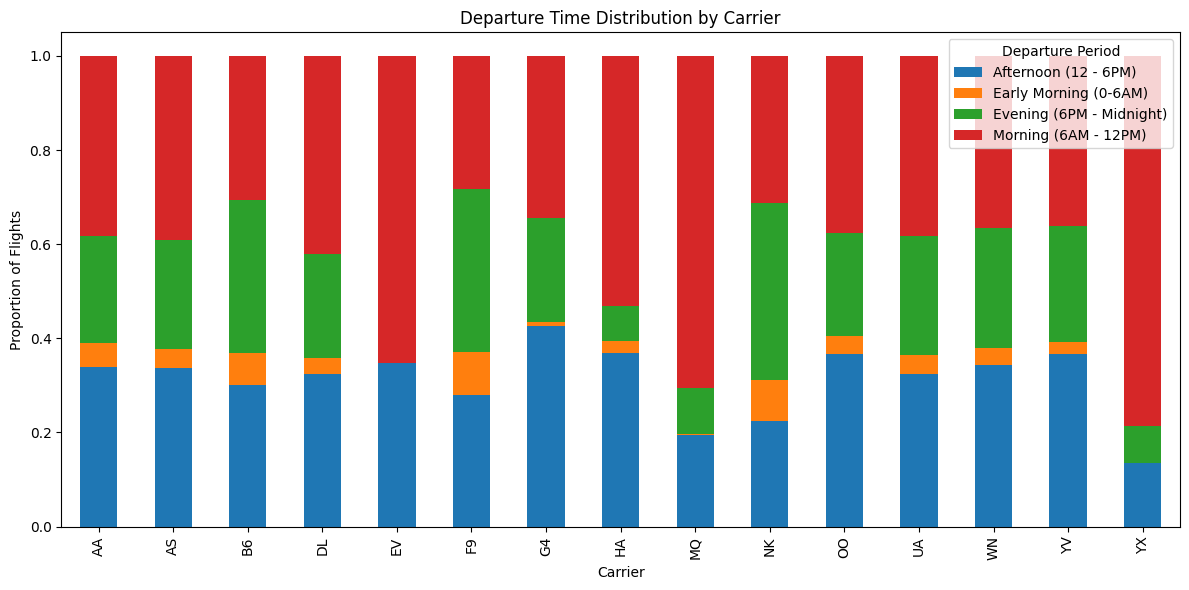

DEP_PERIOD,Afternoon (12 - 6PM),Early Morning (0-6AM),Evening (6PM - Midnight),Morning (6AM - 12PM)
CARRIER_CODE,,,,
AA,0.340066,0.050721,0.227578,0.381635
AS,0.336585,0.040631,0.231731,0.391053
B6,0.300362,0.067860,0.325440,0.306338
DL,0.323760,0.034432,0.221733,0.420075
EV,0.347222,0.000000,0.000000,0.652778
F9,0.280043,0.090697,0.346078,0.283182
G4,0.426511,0.008453,0.219675,0.345361
HA,0.369372,0.024670,0.074807,0.531151
MQ,0.193757,0.002153,0.099031,0.705059


In [55]:
flight_df_dep = df.copy()

def categorize_dep_hour(dep_time):
    if pd.isna(dep_time):
        return 'Unknown'
    hour = int(dep_time) // 100
    if hour < 6:
        return 'Early Morning (0-6AM)'
    elif hour < 12:
        return 'Morning (6AM - 12PM)'
    elif hour < 18:
        return 'Afternoon (12 - 6PM)'
    else:
        return 'Evening (6PM - Midnight)'

flight_df_dep['DEP_PERIOD'] = flight_df_dep['DEP_TIME'].apply(categorize_dep_hour)

def departure_patterns(df, carriers=None):
    if carriers:
        df = df[df['CARRIER_CODE'].isin(carriers)]
    grouped = df.groupby(['CARRIER_CODE', 'DEP_PERIOD']).size().unstack(fill_value=0)
    proportions = grouped.div(grouped.sum(axis=1), axis=0)
    proportions.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title("Departure Time Distribution by Carrier")
    plt.ylabel("Proportion of Flights")
    plt.xlabel("Carrier")
    plt.legend(title="Departure Period")
    plt.tight_layout()
    plt.show()
    return proportions

departure_patterns(flight_df_dep)

This stacked bar chart shows the proportion of flights for each airline across different departure time periods, helping identify scheduling tendencies.

2. Analyze the MINIMUM, MAXIMUM, and AVERAGE ARRIVAL AND DEPARTURE DELAYS for each Airline/Carrier. Visualize the top 10 results. Explain the patterns in the delays and demonstrate: 1) which carriers are more prone to flight delays and 2) are the delays occurring more frequently in certain regions**?

**TIP: it is important to analyze the airlines across multiple airports and/or regions in order to conclude that they have a pattern of being late.

**Top 10 carriers by Average Arrival and Departure Delays**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\1707789249.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = delay_df.groupby('CARRIER_CODE')[['ARR_DELAY', 'DEP_DELAY']].agg(['min', 'max', 'mean'])


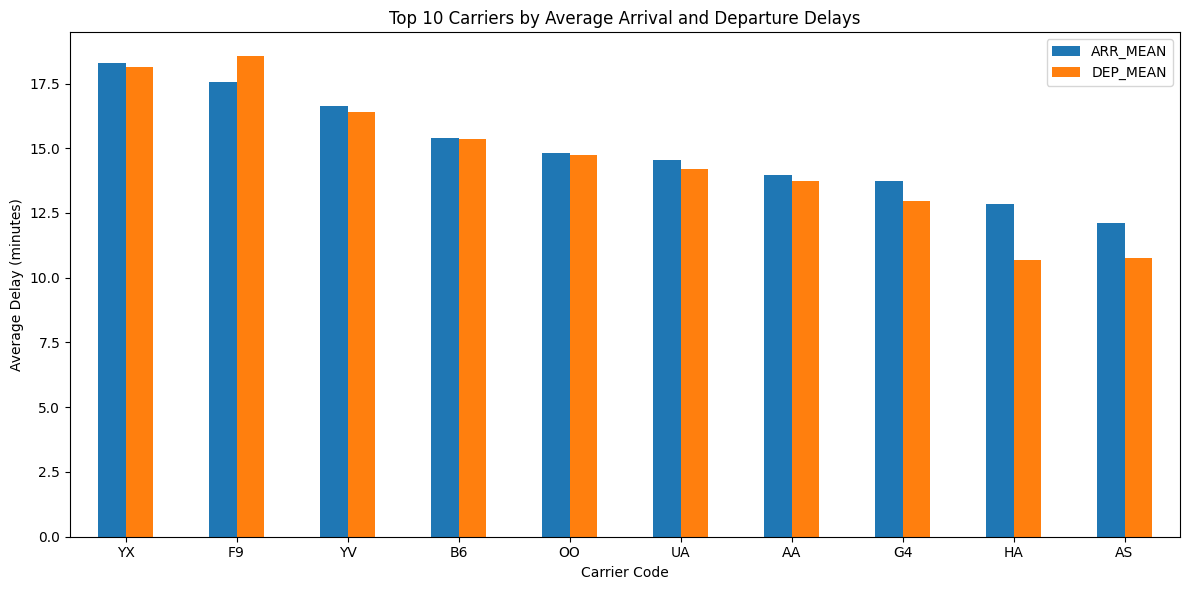

              ARR_MIN  ARR_MAX   ARR_MEAN  DEP_MIN  DEP_MAX   DEP_MEAN
CARRIER_CODE                                                          
YX                  0      481  18.301587        0      500  18.119048
F9                  0      679  17.561047        0      681  18.548387
YV                  0     2206  16.641621        0     2209  16.397214
B6                  0     1756  15.389422        0     1769  15.371686
OO                  0     1909  14.817936        0     1912  14.749788
UA                  0     1516  14.560239        0     1515  14.197509
AA                  0     1933  13.979974        0     1964  13.729003
G4                  0     1532  13.736686        0     1540  12.971365
HA                  0     1117  12.828899        0     1142  10.677126
AS                  0     1087  12.099822        0     1117  10.747917


In [56]:
def avg_delay_stats_by_carrier(df, top_n=10):
    delay_df = df.dropna(subset=['ARR_DELAY', 'DEP_DELAY'])

    stats = delay_df.groupby('CARRIER_CODE')[['ARR_DELAY', 'DEP_DELAY']].agg(['min', 'max', 'mean'])
    stats.columns = ['ARR_MIN', 'ARR_MAX', 'ARR_MEAN', 'DEP_MIN', 'DEP_MAX', 'DEP_MEAN']
    stats = stats.sort_values(by='ARR_MEAN', ascending=False)

    top_stats = stats.head(top_n)

    top_stats[['ARR_MEAN', 'DEP_MEAN']].plot(kind='bar', figsize=(12, 6))
    plt.title(f"Top {top_n} Carriers by Average Arrival and Departure Delays")
    plt.ylabel("Average Delay (minutes)")
    plt.xlabel("Carrier Code")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return top_stats

avg_delay_stats = avg_delay_stats_by_carrier(df, top_n=10)
print(avg_delay_stats)

**Top 10 States by Average Arrival and Departure Delays**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\1394327538.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_delays = regional_df.groupby('ORIGIN_ST')[['ARR_DELAY', 'DEP_DELAY']].mean()


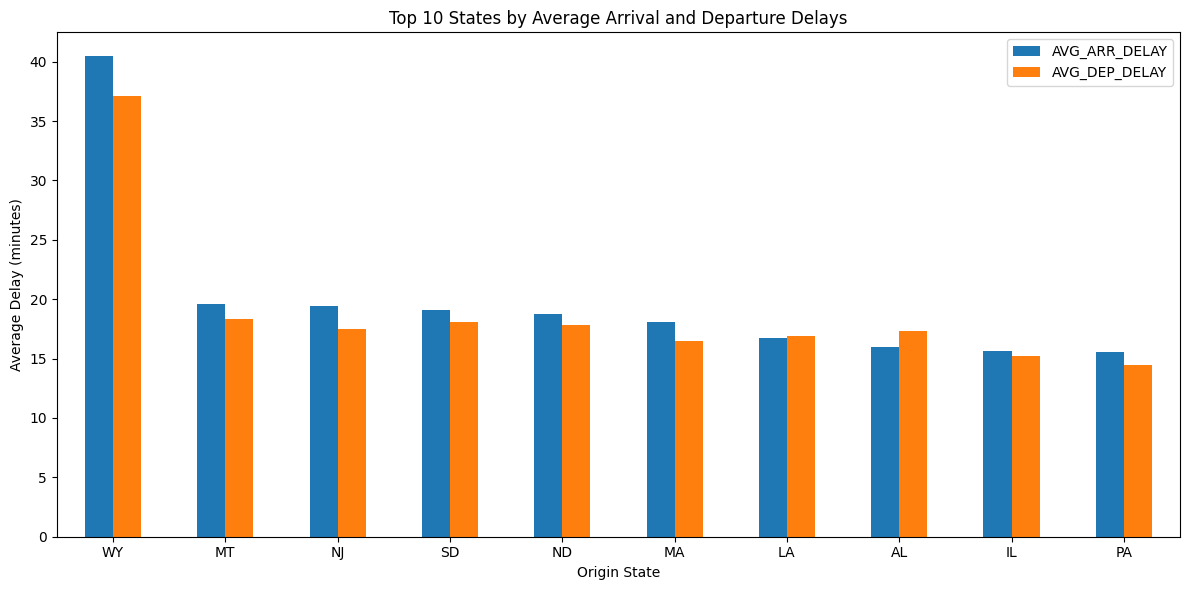

           AVG_ARR_DELAY  AVG_DEP_DELAY
ORIGIN_ST                              
WY             40.444444      37.106481
MT             19.611212      18.346293
NJ              19.39789      17.525057
SD             19.124654      18.078947
ND             18.757771      17.843516
MA             18.069645      16.519588
LA             16.713621      16.928638
AL             15.991525       17.29661
IL             15.604328      15.205183
PA             15.577913      14.436341


In [57]:
def regional_delay_patterns(df, top_n=10):
    regional_df = df.dropna(subset=['ARR_DELAY', 'DEP_DELAY', 'ORIGIN_ST'])

    state_delays = regional_df.groupby('ORIGIN_ST')[['ARR_DELAY', 'DEP_DELAY']].mean()
    state_delays.columns = ['AVG_ARR_DELAY', 'AVG_DEP_DELAY']

    top_states = state_delays.sort_values(by='AVG_ARR_DELAY', ascending=False).head(top_n)

    top_states.plot(kind='bar', figsize=(12, 6))
    plt.title(f"Top {top_n} States by Average Arrival and Departure Delays")
    plt.xlabel("Origin State")
    plt.ylabel("Average Delay (minutes)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return top_states

regional_delay = regional_delay_patterns(df, top_n=10)
print(regional_delay)

**Average Arrival Delay by Carrier and State**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\2968541395.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = delay_data.groupby(['CARRIER_CODE', 'ORIGIN_ST'])['ARR_DELAY'].mean().reset_index()


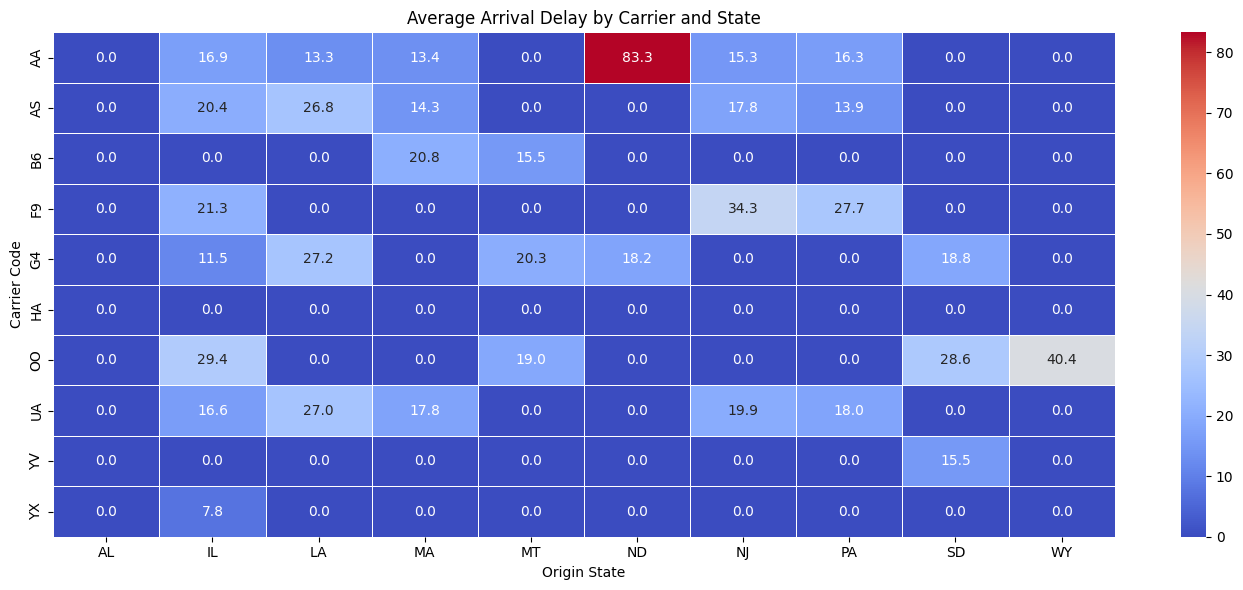

ORIGIN_ST,AL,IL,LA,MA,MT,ND,NJ,PA,SD,WY
CARRIER_CODE,,,,,,,,,,
AA,0.0,16.852952,13.315634,13.437925,0.000000,83.307692,15.289655,16.275847,0.000000,0.000000
AS,0.0,20.366667,26.790000,14.330996,0.000000,0.000000,17.791932,13.898551,0.000000,0.000000
B6,0.0,0.000000,0.000000,20.781621,15.483871,0.000000,0.000000,0.000000,0.000000,0.000000
F9,0.0,21.297297,0.000000,0.000000,0.000000,0.000000,34.318841,27.730159,0.000000,0.000000
G4,0.0,11.531697,27.178571,0.000000,20.325959,18.201774,0.000000,0.000000,18.791480,0.000000
HA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OO,0.0,29.400000,0.000000,0.000000,19.043814,0.000000,0.000000,0.000000,28.609195,40.444444
UA,0.0,16.569644,26.974074,17.842207,0.000000,0.000000,19.942506,17.964654,0.000000,0.000000
YV,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.544974,0.000000


In [58]:
import seaborn as sns

def arr_delay_patterns_by_airline_and_region(df, top_carriers=None, top_states=None):
    delay_data = df.dropna(subset=['ARR_DELAY', 'CARRIER_CODE', 'ORIGIN_ST'])

    grouped = delay_data.groupby(['CARRIER_CODE', 'ORIGIN_ST'])['ARR_DELAY'].mean().reset_index()

    if top_carriers:
        grouped = grouped[grouped['CARRIER_CODE'].isin(top_carriers)]
    if top_states:
        grouped = grouped[grouped['ORIGIN_ST'].isin(top_states)]

    pivot = grouped.pivot(index='CARRIER_CODE', columns='ORIGIN_ST', values='ARR_DELAY').fillna(0)

    pivot = pivot.astype(float)

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
    plt.title("Average Arrival Delay by Carrier and State")
    plt.xlabel("Origin State")
    plt.ylabel("Carrier Code")
    plt.tight_layout()
    plt.show()

    return pivot

# extract top 10 arrival carriers
top_arr_carriers = avg_delay_stats.sort_values(by='ARR_MEAN', ascending=False).head(10).index.tolist()

# extract top 10 arrival states
top_arr_states = regional_delay.sort_values(by='AVG_ARR_DELAY', ascending=False).head(10).index.tolist()

arr_delay_patterns_by_airline_and_region(df, top_arr_carriers, top_arr_states)


**Average Depature Delay by Carrier and State**

C:\Users\gauri\AppData\Local\Temp\ipykernel_25316\1975795343.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = delay_data.groupby(['CARRIER_CODE', 'ORIGIN_ST'])['DEP_DELAY'].mean().reset_index()


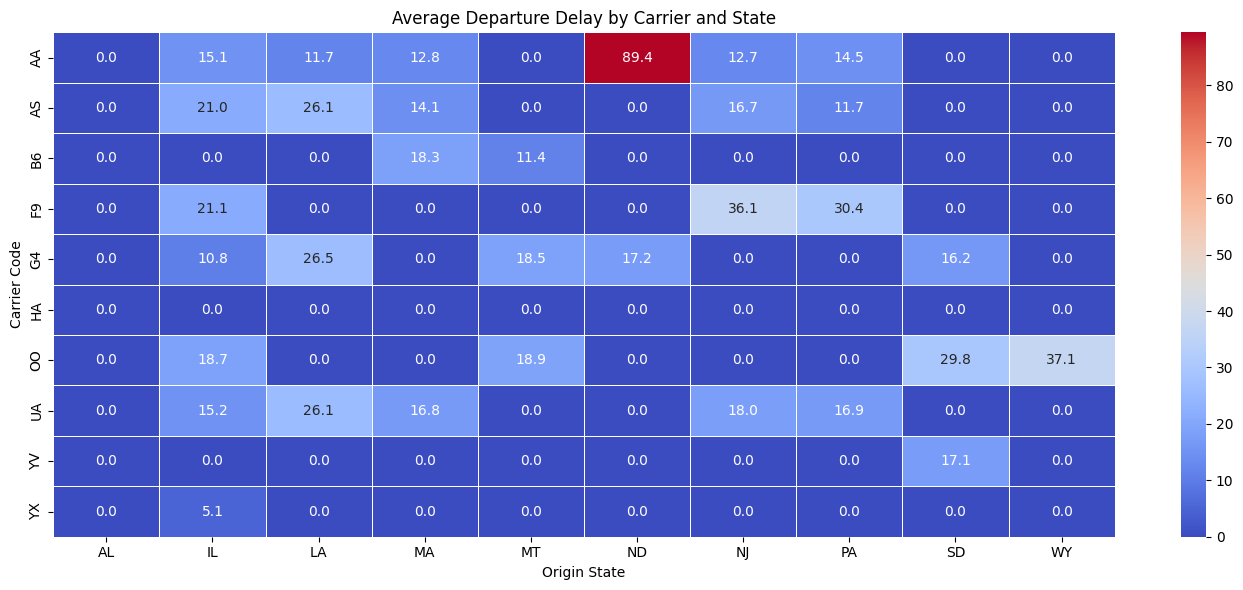

ORIGIN_ST,AL,IL,LA,MA,MT,ND,NJ,PA,SD,WY
CARRIER_CODE,,,,,,,,,,
AA,0.0,15.092321,11.722714,12.752934,0.000000,89.384615,12.668966,14.538879,0.000000,0.000000
AS,0.0,21.010417,26.095000,14.054698,0.000000,0.000000,16.656759,11.663043,0.000000,0.000000
B6,0.0,0.000000,0.000000,18.263533,11.387097,0.000000,0.000000,0.000000,0.000000,0.000000
F9,0.0,21.081081,0.000000,0.000000,0.000000,0.000000,36.086957,30.365079,0.000000,0.000000
G4,0.0,10.787321,26.464286,0.000000,18.541298,17.168514,0.000000,0.000000,16.201794,0.000000
HA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OO,0.0,18.666667,0.000000,0.000000,18.922680,0.000000,0.000000,0.000000,29.770115,37.106481
UA,0.0,15.179547,26.125926,16.838358,0.000000,0.000000,18.013660,16.901325,0.000000,0.000000
YV,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.126984,0.000000


In [59]:
def dep_delay_patterns_by_airline_and_region(df, top_carriers=None, top_states=None):
    delay_data = df.dropna(subset=['DEP_DELAY', 'CARRIER_CODE', 'ORIGIN_ST'])

    grouped = delay_data.groupby(['CARRIER_CODE', 'ORIGIN_ST'])['DEP_DELAY'].mean().reset_index()

    if top_carriers:
        grouped = grouped[grouped['CARRIER_CODE'].isin(top_carriers)]
    if top_states:
        grouped = grouped[grouped['ORIGIN_ST'].isin(top_states)]

    pivot = grouped.pivot(index='CARRIER_CODE', columns='ORIGIN_ST', values='DEP_DELAY').fillna(0)

    pivot = pivot.astype(float)

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
    plt.title("Average Departure Delay by Carrier and State")
    plt.xlabel("Origin State")
    plt.ylabel("Carrier Code")
    plt.tight_layout()
    plt.show()

    return pivot

# extract top 10 departure carriers
top_dep_carriers = avg_delay_stats.sort_values(by='DEP_MEAN', ascending=False).head(10).index.tolist()

# extract top 10 departure states
top_dep_states = regional_delay.sort_values(by='AVG_DEP_DELAY', ascending=False).head(10).index.tolist()

dep_delay_patterns_by_airline_and_region(df, top_dep_carriers, top_dep_states)

In [60]:
# filter flights operated by AA that originated in ND
# exclude any records with missing arrival or departure delay data
aa_nd_flights = df[
    (df['CARRIER_CODE'] == 'AA') &
    (df['ORIGIN_ST'] == 'ND') &
    (~df['ARR_DELAY'].isna()) &
    (~df['DEP_DELAY'].isna())
]

# calculate how many such flights exist and summarize their delay statistics.
aa_nd_count = len(aa_nd_flights)
aa_nd_summary = aa_nd_flights[['ARR_DELAY', 'DEP_DELAY']].describe()

aa_nd_count, aa_nd_summary

(13,
         ARR_DELAY   DEP_DELAY
 count        13.0        13.0
 mean    83.307692   89.384615
 std    272.235004  279.883172
 min           0.0         0.0
 25%           0.0         0.0
 50%           0.0         0.0
 75%           0.0        17.0
 max         986.0      1017.0)

1) Regional and low-cost carriers such as Republic Airways (YX), Frontier Airlines (F9), and Mesa Airlines (YV) are more prone to flight delays, with the highest average arrival and departure delays across the dataset. These airlines typically operate on tighter schedules with limited fleet flexibility, making them more vulnerable to disruption. In contrast, larger carriers like Alaska (AS) and Hawaiian (HA) demonstrated more reliable performance, with consistently lower average delays.

2) Yes, delays are more frequent in specific regions. States like Wyoming (WY), Montana (MT), and New Jersey (NJ) consistently showed high average delays, driven by factors such as weather conditions or airspace congestion. One notable case was American Airlines in North Dakota (ND), which showed extremely high average delays. However, this was based on only 13 flights and skewed by outliers, so it shouldn't be interpreted as a consistent pattern.

## Question 5

## Question 6

## Question 7